In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Part 1 - EDA

In [44]:
df = pd.read_json('logins.json')

In [45]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [47]:
df.isnull().sum()

login_time    0
dtype: int64

In [48]:
df = df.set_index('login_time')

In [50]:
df['login_count'] = 1

In [51]:
df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [52]:
#resample the timestamp into 15 min periods and use the sum function as the aggregate
df_15_delta = df.resample('15min').sum()

In [53]:
df_15_delta.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


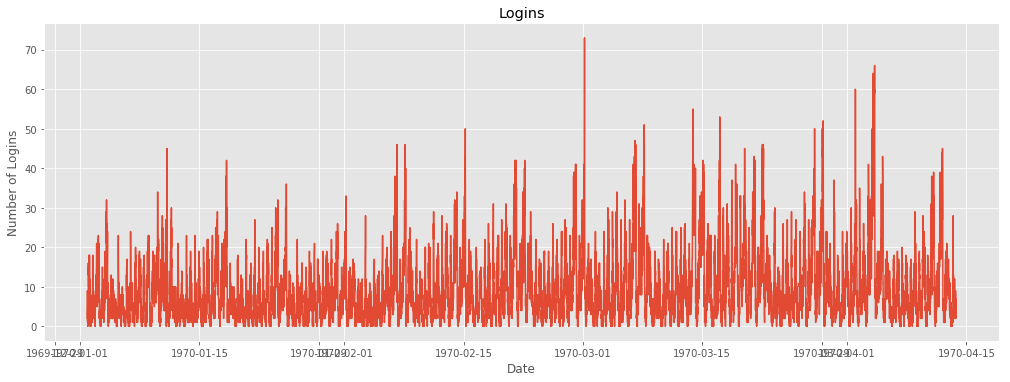

In [62]:
fig, ax = plt.subplots(figsize = (14,5))
plt.tight_layout()
# puts the data in the figure

y = df_15_delta.login_count
x = df_15_delta.index
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.title('Logins')
plt.show()

Aggregating the logins into 15 minute bins by re-sampling the timestamps shows that there are somewhat consistent spikes in the logins but it's hard to tell from this graph what the pattern is.

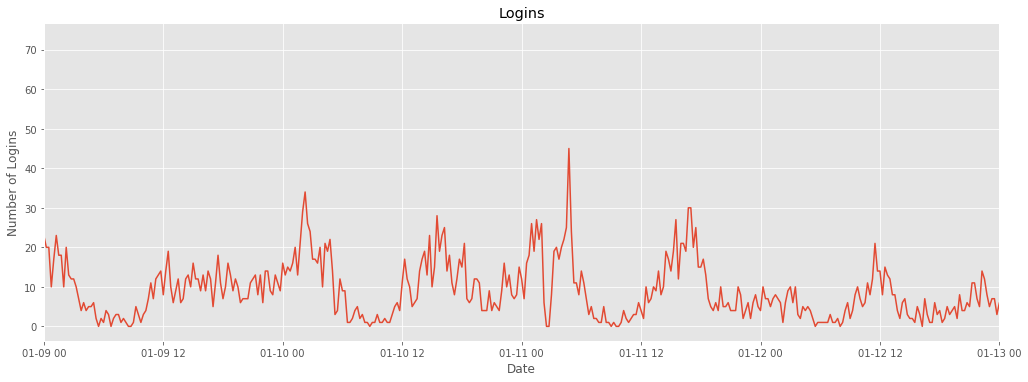

In [66]:
fig, ax = plt.subplots(figsize = (14,5))
plt.tight_layout()
# puts the data in the figure

y = df_15_delta.login_count
x = df_15_delta.index
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.title('Logins')
plt.xlim('1-9-1970','1-13-1970')
plt.show()

It's easier to tell that there seems to be spikes in the mornings and evening hours, but only for certain days. We'll have to re-sample the timestamps accordingly to get more insight.

In [76]:
day.head()

,login_count,day
login_time,,
1970-01-01,112,3
1970-01-02,2262,4
1970-01-05,459,0
1970-01-06,536,1
1970-01-07,648,2


In [72]:
df_business.head()

,login_count
login_time,
1970-01-01,112
1970-01-02,2262
1970-01-05,459
1970-01-06,536
1970-01-07,648


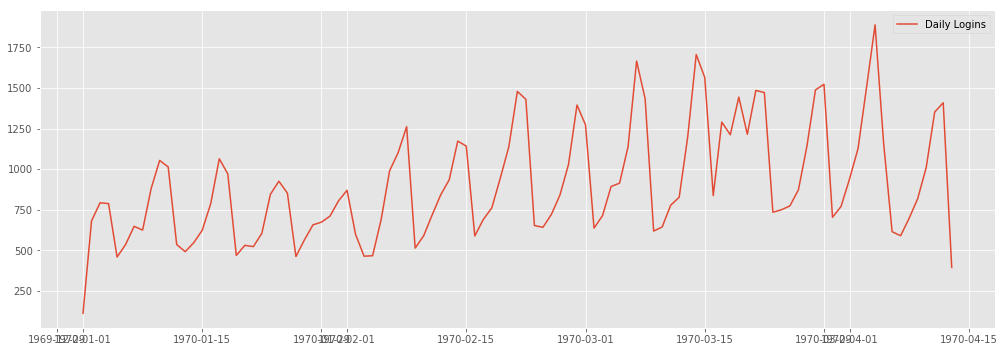

In [87]:
df_daily = df.resample('D').sum()

fig, ax = plt.subplots(figsize = (14,5))
plt.tight_layout()
# puts the data in the figure

plt.plot(df_daily.index, df_daily.login_count)

plt.legend(['Daily Logins', 'Business Day'])

Aggregating by Day we can see that there is a weekly pattern. Let's add a day column and see which days are the busiest

In [132]:
day = df_daily

In [133]:
day['day'] = day.index.weekday

In [134]:
day.head()

,login_count,day,hour
login_time,,,
1970-01-01,112,3,0
1970-01-02,681,4,0
1970-01-03,793,5,0
1970-01-04,788,6,0
1970-01-05,459,0,0


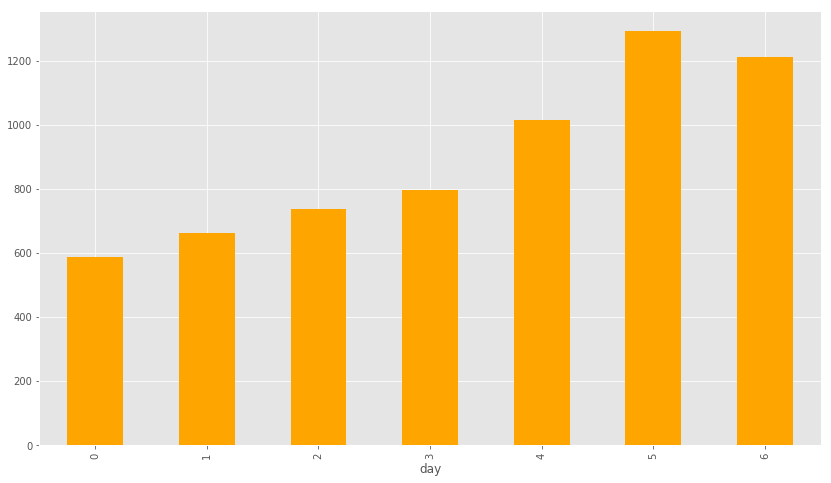

In [135]:
day.groupby('day')['login_count'].mean().plot(kind='bar', color='orange')

Saturdays and Sundays have the most logins. We can look at daily activity next.

In [136]:
hour = df

In [137]:
hour['hour'] = hour.index.hour

In [138]:
hour.head()

,login_count,day,hour
login_time,,,
1970-01-01 20:13:18,1,3,20
1970-01-01 20:16:10,1,3,20
1970-01-01 20:16:37,1,3,20
1970-01-01 20:16:36,1,3,20
1970-01-01 20:26:21,1,3,20


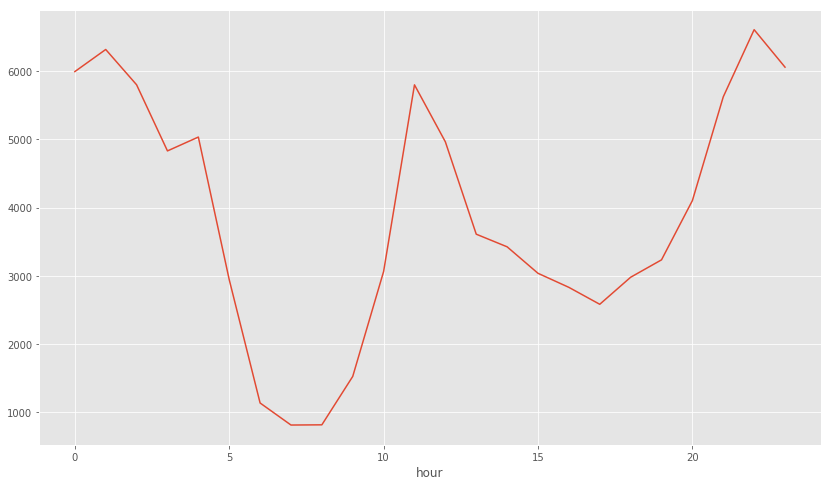

In [147]:
hour.groupby(['hour'])['login_count'].size().plot()

On average, we have a peak in logins around lunchtime and in the evening / night hours.

# Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Being and Ultimate manager my goal would be to better serve my customer (riders) as the first priority and driver partners as the second priority. By reimbursing all toll costs, we want to encourage driver partners to be available when the demand is high, at Gotham at night and Metropolis during the day. Assuming we have passenger data and driver data, we can measure the average weight times a passenger experiences. We want to reduce wait times in order to increase ridership -> increasing revenue. We can also measure number of cancellations by the driver / passenger. If a passenger waits too long, they might choose to cancel the ride. Likewise, at times the driver can contact the passenger to ask for the final destination and cancel the ride if it's not favorable. In both scenarios the cancellation should rate should decrease if there are more drivers willing to make the trip across the bridge.
To actually understand the change in driver partner patterns we can look at the rate of bridge crossings per day for the drivers.


However, this is a experiment makes an assumption that driver partners don't make the trip across the bridge because the toll eats into their profit. We can make another assumption: the drivers don't make the trip across the bridge because the customer demand is highly sensitive to time.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
    a. how you will implement the experiment
    
        This experiment can be implemented as an A/B test (implement the change for some drivers) or using past data and implementing a change for all drivers. With key metrics being change in customer wait times, overall cancellation rates, and bridge crossing rates.
        My hypotheses would be as follows:
        H0-wait time: there is no difference in the mean wait times between the control and test groups
        HA-wait time: there is a significant difference in wait times between the control and test groups
        
        H0-cancellation rate: there is no difference in the mean cancellation rates between the control and test groups
        HA-cancellation rate: there is a significant difference in cancellation rates between the control and test groups
        
        H0-bridge crossing rate: there is no difference in the bridge cross rates between the control and test groups
        HA-bridge crossing rate: there is a significant difference in bridge cross rates between the control and test groups

  
    b. what statistical test(s) you will conduct to verify the significance of the
    observation
        
       Results from the control group would be compared to the test group (reimbursed drivers) 
         Implementing a one tailed Z-test with a P-value of 0.05 or more to reject the null hypothesis.
         
    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.
    
        P-value of 0.05 or more to reject the null hypothesis.

# Predictive Modeling

In [178]:
import seaborn as sns
from datetime import date, timedelta

In [150]:
# load data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

In [151]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [152]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [164]:
user_data['last_trip_date'] = pd.to_datetime(user_data.last_trip_date)

In [170]:
user_data['signup_date'] = pd.to_datetime(user_data.signup_date)

In [171]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [154]:
user_data.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [260]:
user_data.groupby('phone').size()

phone
Android    15022
iPhone     34582
dtype: int64

In [268]:
#let's fill in the missing ratings with a mean and average phone with iphone, the more popular phone.
user_data['phone'] = user_data.phone.fillna('iPhone')
user_data['avg_rating_by_driver'] = user_data.avg_rating_by_driver.fillna(user_data.avg_rating_by_driver.mean())
user_data['avg_rating_of_driver'] = user_data.avg_rating_of_driver.fillna(user_data.avg_rating_of_driver.mean())

In [269]:
user_data.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
weekday                   0
weekend                   0
active                    0
all_count                 0
dtype: int64

In [155]:
user_data.last_trip_date.max()

'2014-07-01'

In [156]:
user_data.last_trip_date.min()

'2014-01-01'

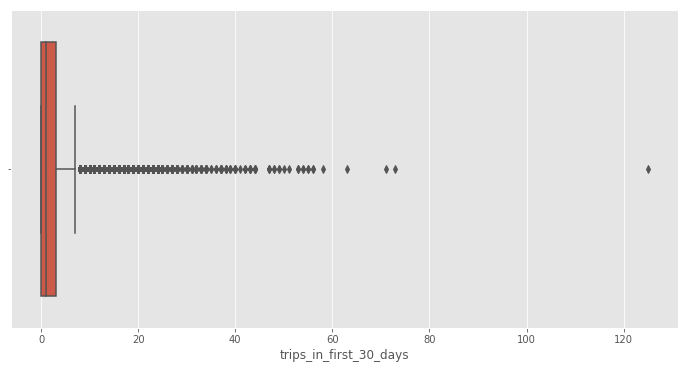

In [181]:
fig, ax = plt.subplots(figsize = (10,5))
plt.tight_layout()
sns.boxplot(user_data.trips_in_first_30_days)

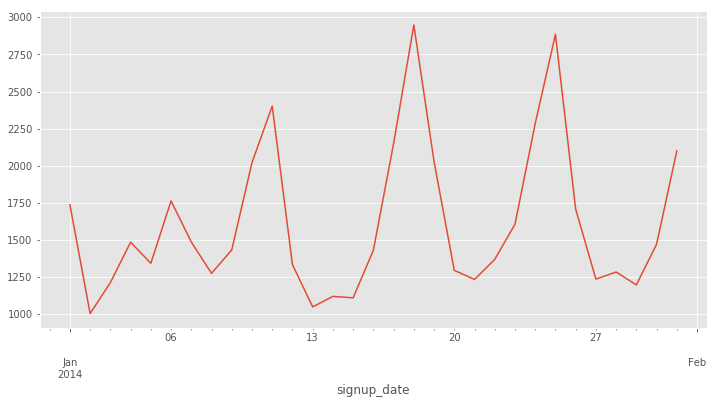

In [182]:
fig, ax = plt.subplots(figsize = (10,5))
plt.tight_layout()
user_data.groupby('signup_date').size().plot()

There are spikes in when users tend to sign up. Looks like the spike occurs on a weekly basis.

In [249]:
user_data['weekday'] = user_data.signup_date.apply(lambda x: x.weekday())
user_data['all_count'] = 1

In [189]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,weekday
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,5
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,4
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


(-5, 60)

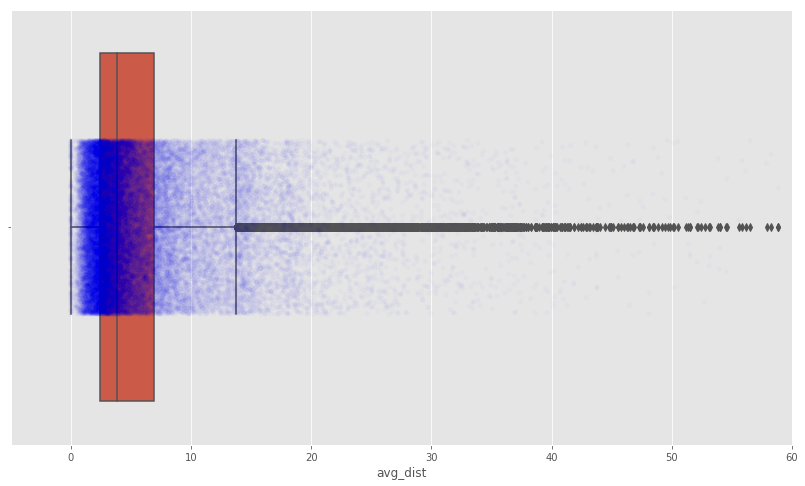

In [244]:
sns.boxplot(user_data.avg_dist)
sns.stripplot(user_data.avg_dist, alpha=0.02, color='blue', jitter=0.2)
plt.xlim(-5,60)

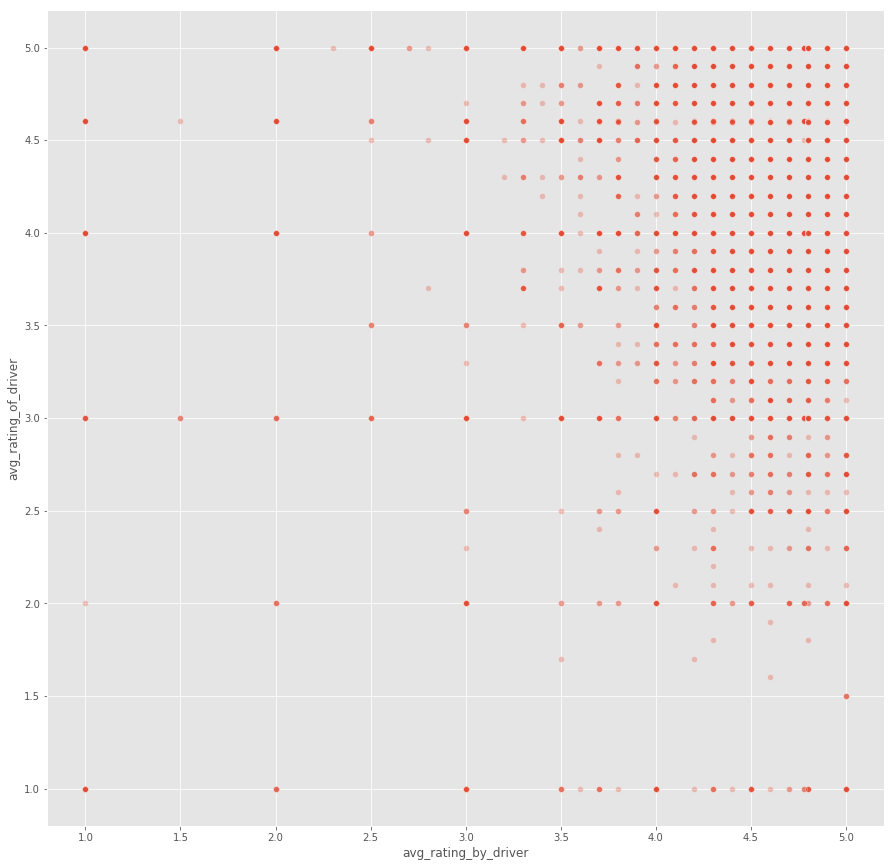

In [270]:
sns.scatterplot(x='avg_rating_by_driver', y='avg_rating_of_driver', data=user_data, alpha=0.3)

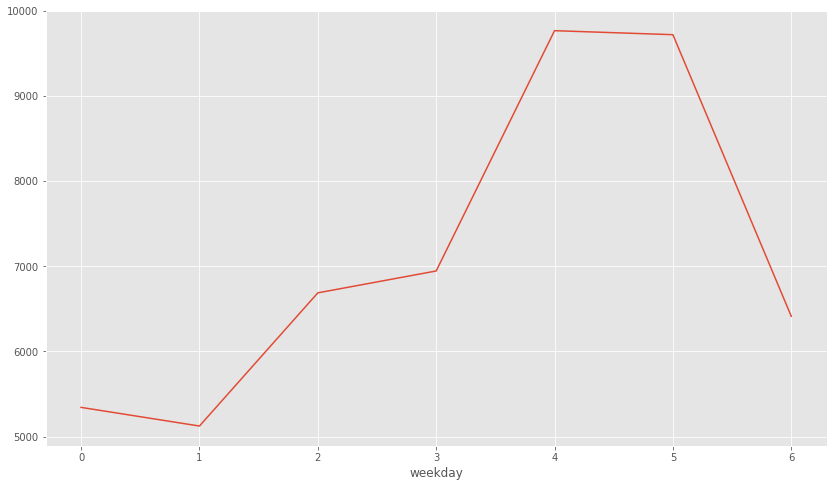

In [198]:
user_data.groupby('weekday').size().plot()

We were right, there is a spike in user signups every seven days. Most users sign up on Friday and Saturday. Maybe they need a ride after going out? Next question that comes to mind is, how many rides do the users take in the first 30 days that signup on Friday and Saturday?

In [210]:
user_data['weekend'] = user_data.weekday.apply(lambda x: 'weekend' if x == 4 or x == 5 else 'weekday')

In [211]:
user_data.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,weekday,count,weekend
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,5,1,weekend
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2,1,weekday
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,1,weekday
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,4,1,weekend
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,1,weekday


In [231]:
print(f'mean trips in first 30 days after signing up on the weekend:{user_data.groupby("weekend")["trips_in_first_30_days"].mean()}')
print(f'max trips in first 30 days after signing up on the weekday:{user_data.groupby("weekend")["trips_in_first_30_days"].max()}')

mean trips in first 30 days after signing up on the weekend:weekend
weekday    2.309901
weekend    2.228563
Name: trips_in_first_30_days, dtype: float64
max trips in first 30 days after signing up on the weekday:weekend
weekday    125
weekend     63
Name: trips_in_first_30_days, dtype: int64


There is a difference in trips taken in the first 30 days after signup

In [177]:
cut_off_date = user_data.last_trip_date.max() - timedelta(31)
cut_off_date

Timestamp('2014-05-31 00:00:00')

## Qualifying users as Active or Inactive

In [245]:
#Assuming that last trip date is the last data we have, we can assume that if a user didn't take a ride
#30 days prior to this last trip date, they are innactive. We will quantify innactive users as 0 and active as 1
user_data['active'] = user_data.last_trip_date.apply(lambda x: 1 if x > cut_off_date else 0)

In [251]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,weekday,weekend,active,all_count
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,5,weekend,1,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2,weekday,0,1
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,weekday,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,4,weekend,1,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,weekday,0,1


In [254]:
print(f'Fraction of Active Users: {user_data.active.sum()/user_data.all_count.sum()}')

Fraction of Active Users: 0.37608


## Modeling

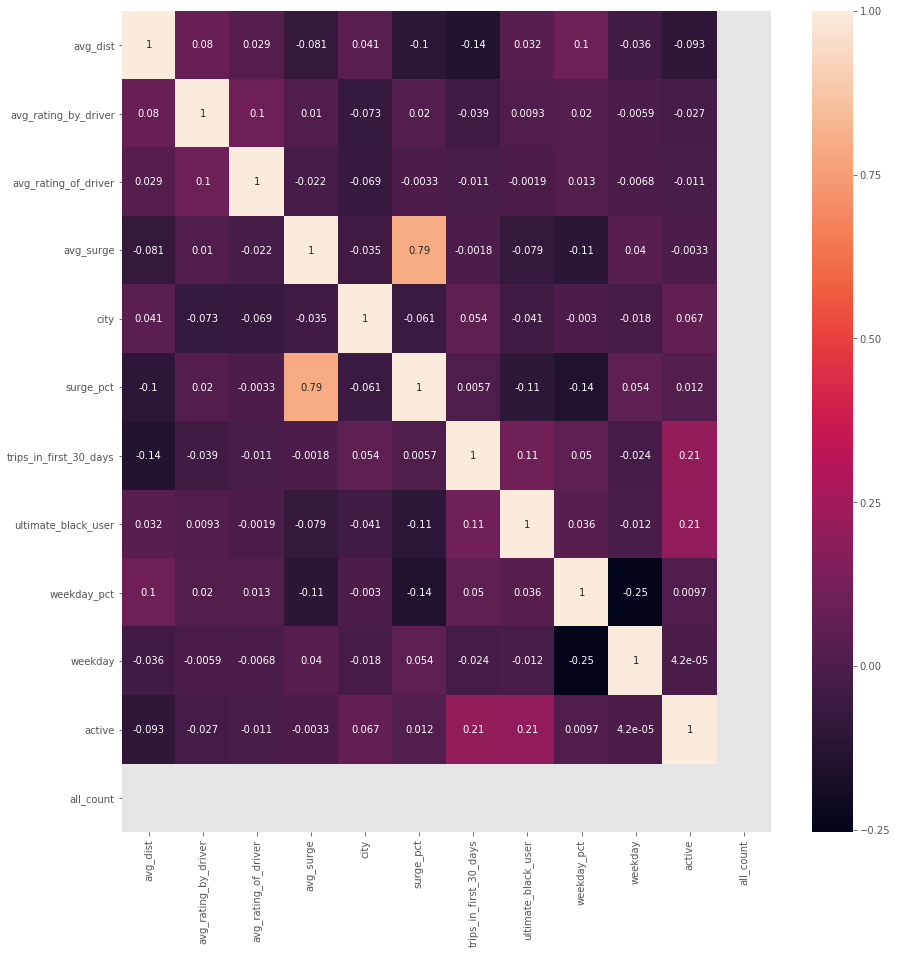

In [271]:
fig, ax = plt.subplots(figsize = (12,12))
plt.tight_layout()
matplotlib.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(data=user_data.corr(), annot=True)

In [258]:
#import label encoder and onehotencoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

In [272]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,weekday,weekend,active,all_count
0,3.67,5.0,4.7,1.10,1,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,5,weekend,1,1
1,8.26,5.0,5.0,1.00,0,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2,weekday,0,1
2,0.77,5.0,4.3,1.00,0,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,weekday,0,1
3,2.36,4.9,4.6,1.14,1,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,4,weekend,1,1
4,3.13,4.9,4.4,1.19,2,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,weekday,0,1


In [278]:
#encoding columns
user_data['city'] = le.fit_transform(user_data.city.values)
user_data['phone'] = le.fit_transform(user_data.phone.values)
user_data['weekend'] = le.fit_transform(user_data.weekend.values)

user_data['last_trip_date'] = le.fit_transform(user_data.last_trip_date.values)
user_data['signup_date'] = le.fit_transform(user_data.signup_date.values)

In [279]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,weekday,weekend,active,all_count
0,3.67,5.0,4.7,1.10,1,167,1,24,15.4,4,True,46.2,5,1,1,1
1,8.26,5.0,5.0,1.00,0,124,0,28,0.0,0,False,50.0,2,0,0,1
2,0.77,5.0,4.3,1.00,0,6,1,5,0.0,3,False,100.0,0,0,0,1
3,2.36,4.9,4.6,1.14,1,179,1,9,20.0,9,True,80.0,4,1,1,1
4,3.13,4.9,4.4,1.19,2,73,0,26,11.8,14,False,82.4,0,0,0,1


Let's make sure that we don't have any features that are correlated with the target column

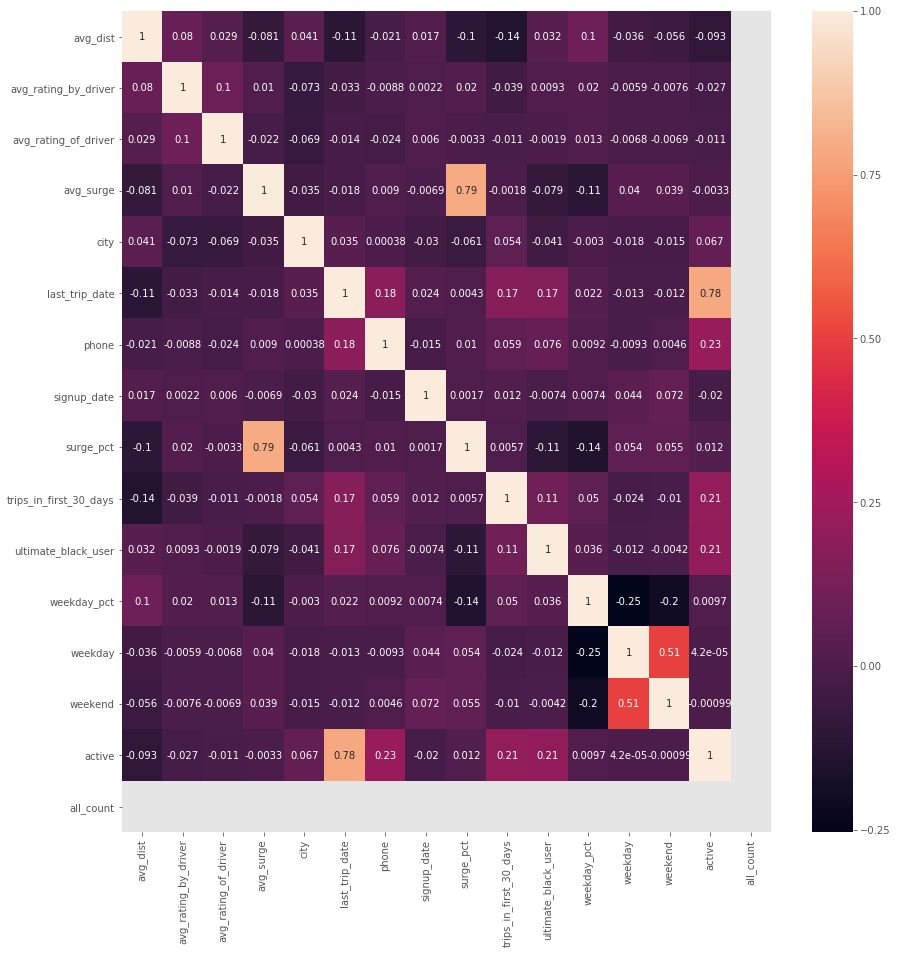

In [295]:
fig, ax = plt.subplots(figsize = (12,12))
plt.tight_layout()
matplotlib.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(data=user_data.corr(), annot=True)

In [296]:
#we'll need to take out 'last_trip_date' because this column is what is determining our target column.
y = user_data.active.values
X = user_data.drop(columns=['active','last_trip_date']).values

In [297]:
cols = list(user_data.drop(columns=['active','last_trip_date']).columns)

In [298]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Naive Bayes

Let's start with a fast and easy binary classification algorithm with minimal tuning options, Naive Bayes

In [299]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [300]:
y_pred = gnb.predict(X_test)

In [301]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6844


In [302]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[4260, 1959],
       [1197, 2584]])

In [303]:
y_prob = gnb.predict_proba(X_test)[::,1]

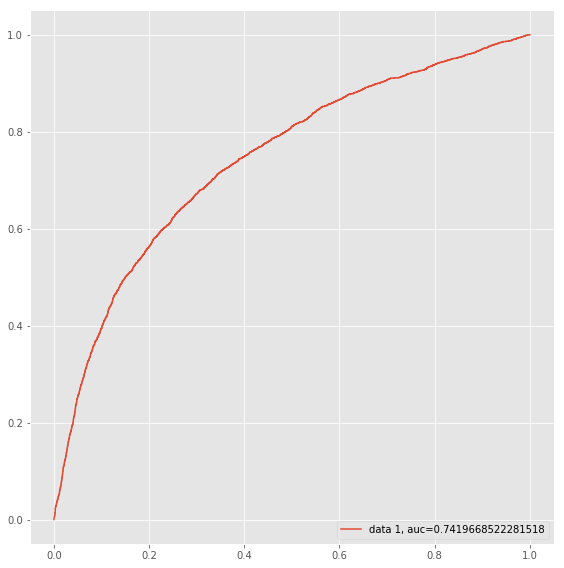

In [304]:
fig, ax = plt.subplots(figsize = (8,8))
plt.tight_layout()

y_pred_proba = y_prob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random Forest

In [305]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [306]:
y_pred_rf = rf.predict(X_test)

In [307]:
cm1 = confusion_matrix(y_test, y_pred_rf)
y_prob = rf.predict_proba(X_test)[::,1]

#find important features
feature_imp = pd.Series(rf.feature_importances_,index=cols).sort_values(ascending=False)
feature_imp

avg_dist                  0.200189
weekday_pct               0.129488
avg_rating_by_driver      0.109143
signup_date               0.093176
surge_pct                 0.071952
avg_rating_of_driver      0.071643
city                      0.070830
trips_in_first_30_days    0.070729
avg_surge                 0.058566
weekday                   0.047468
phone                     0.035470
ultimate_black_user       0.030553
weekend                   0.010793
all_count                 0.000000
dtype: float64

In [308]:
cm1

array([[5302,  917],
       [1548, 2233]])

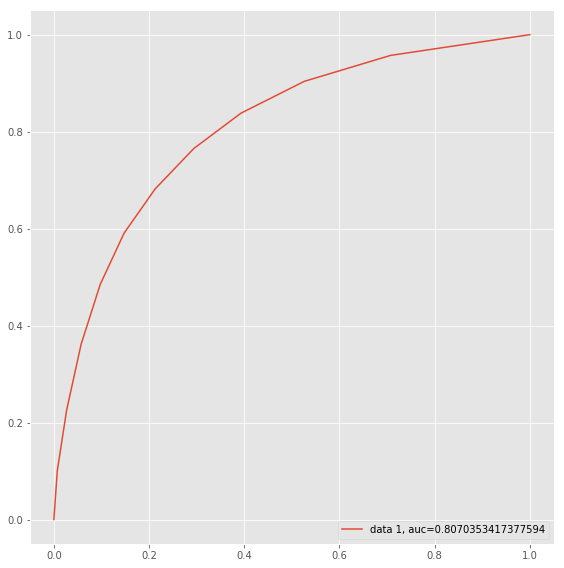

In [309]:
fig, ax = plt.subplots(figsize = (8,8))
plt.tight_layout()

y_pred_proba = y_prob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Tunning

In [334]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 80, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 12, 14, 16, 18, 21, 23, 25, 27, 30, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [4, 6, 8],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 65, 80]}


In [335]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, \
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [50, 65, 80], 'max_features': ['sqrt'], 'max_depth': [10, 12, 14, 16, 18, 21, 23, 25, 27, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [4, 6, 8], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [336]:
rf_random.best_params_

{'n_estimators': 65,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': True}

In [357]:
rf_tunned = RandomForestClassifier(n_estimators=65, min_samples_split=2, min_samples_leaf=8,
                                  max_features='sqrt', max_depth=25, bootstrap=True)
rf_tunned.fit(X_train, y_train)
y_pred_rf = rf_tunned.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred_rf)
y_prob = rf_tunned.predict_proba(X_test)[::,1]
#find important features
feature_imp = pd.Series(rf_tunned.feature_importances_,index=cols).sort_values(ascending=False)
print(feature_imp)
print(cm1)

avg_rating_by_driver      0.155284
weekday_pct               0.124375
surge_pct                 0.119080
city                      0.112234
avg_surge                 0.090546
avg_dist                  0.085860
phone                     0.066740
trips_in_first_30_days    0.064992
ultimate_black_user       0.059828
signup_date               0.047196
avg_rating_of_driver      0.039640
weekday                   0.027339
weekend                   0.006888
all_count                 0.000000
dtype: float64
[[5408  811]
 [1369 2412]]


Our model was able to predict 5410 inactive users accurately (87%). This is an important metric to look at since we'd want to be able to predict users that will become inactive and intervene prior to the user becoming inactive. Biggest contributer to us predicting whether whether a user will become inactive comes from the feature importance matrix.

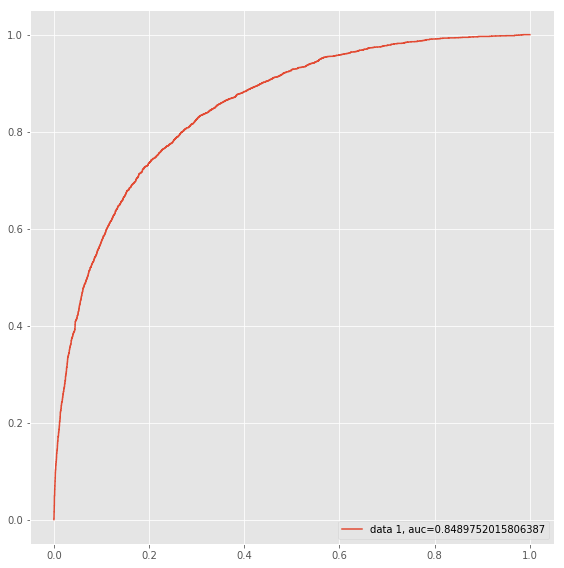

In [339]:
fig, ax = plt.subplots(figsize = (8,8))
plt.tight_layout()

y_pred_proba = y_prob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [340]:
# Model Accuracy, how often is the classifier correct?
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.7819


#### Cross Validation

In [341]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [342]:
score = cv_score(rf_tunned, X_train, y_train)
print("Accuracy:",score)

Accuracy: 0.7804
